In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [19]:
columns = ["class", "Alcohol","Malic acid","Ash","Alcalinity of ash","Magnesium","Total phenols","Flavanoids",
           "Nonflavanoid phenols","Proanthocyanins","Color intensity","Hue","OD280/OD315 of diluted wines","Proline" ]
classes_names = [1,2,3]
raw_data = pd.read_csv("wine.data", sep=",", names=columns)
raw_data

,class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


### 2. Modèle à base de règles

Utilisez les box-plots des variables qui ont une majorité de valeurs différentes pour
les différentes classes afin de programmer des règles (if-then-else) permettant la
classification de chaque observation. a) Essayez au moins trois variables de
manière individuelle et b) deux classificateurs à multiples variables (p.ex., deux ou
trois) et évaluez le nombre d’observations qui sont correctement classées
(accuracy) par ses modèles.
----------------------------------------------------------------------------------------
#### partie a)

Nous commençons tout d'abord par analyser la répartition des données selon les catégories. Nous ciblons pour ce faire chacune
des caractéristiques à l'aide de boxplots.

Ceci nous permettra par la suite de sélectionner des caractéristiques dont les valeurs diffèrent fortement selon les classes.
Nous pourrons ainsi établir nos règles en nous basant sur ces dernières.

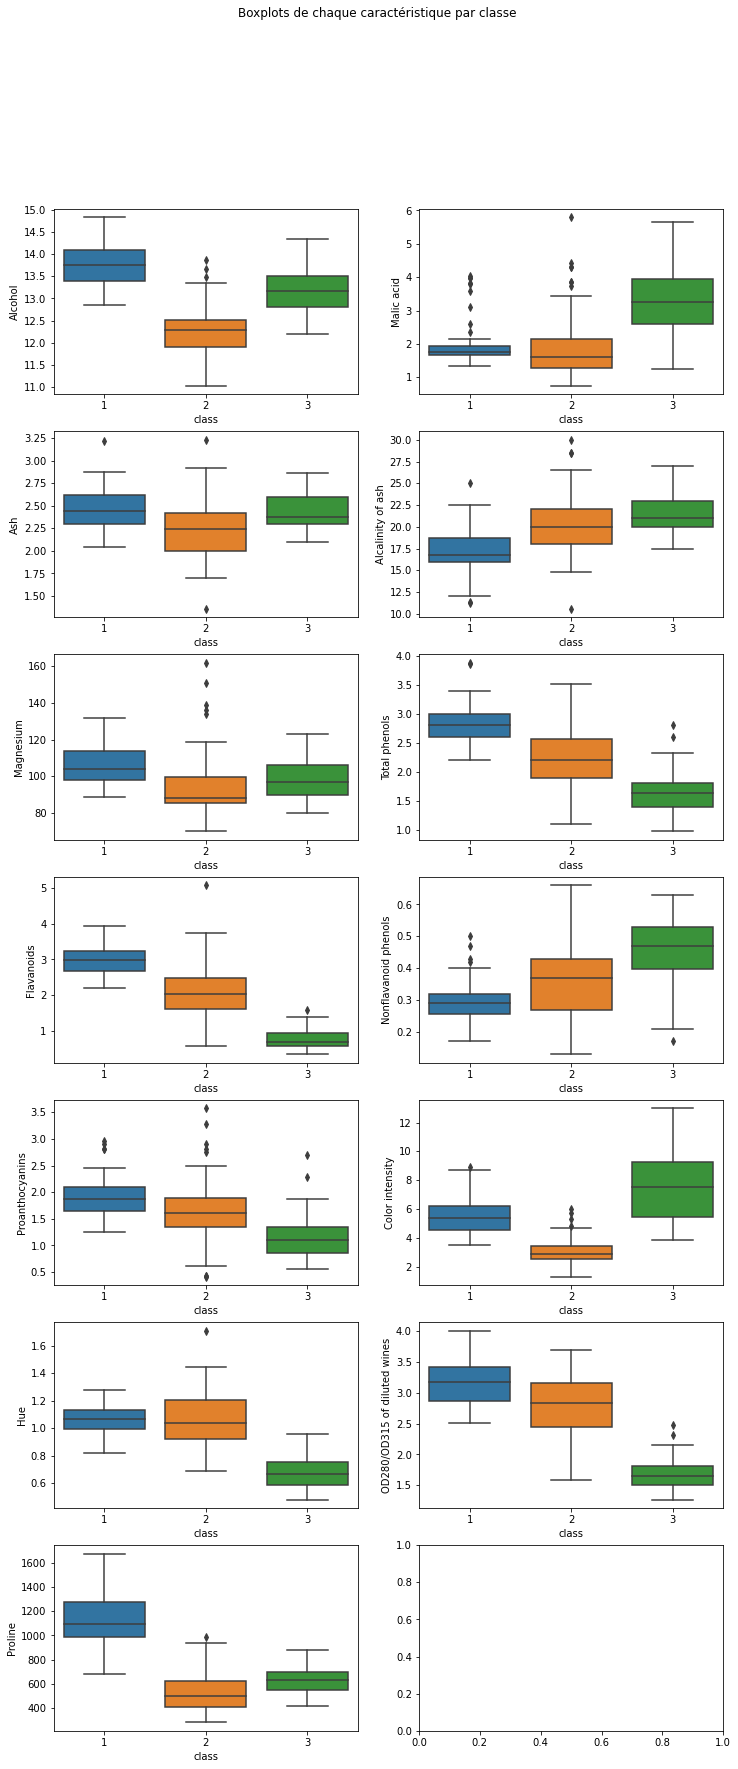

In [20]:
# extraction des noms des caractéristiques (en évitant la colonne 'class')
caracteristics = raw_data.columns[1:]

# calcul tailles + nombre des boxplots
ncols = 2
nrows = math.ceil(len(caracteristics) / 2)
figsize = (ncols * 6, nrows * 4)

# génération des boxplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
fig.suptitle('Boxplots de chaque caractéristique par classe')

elNum = 0
for line in axes :
    for element in line :
        if(elNum < len(caracteristics)):
            sns.boxplot(ax=element, data=raw_data, x='class', y=caracteristics[elNum])
        elNum += 1

Sur la base des boxplots ci-dessus nous pouvons tirer les conclusions suivantes :

* les caractéristiques "Flavanoids", "Total phenols", "Alcohol" (et eventuellement "Nonflavanoid phenols") sont de bons candidats sur lequels appuyer les règles de notre modèle.

En effet nous pouvons remarquer que de manière générale les plages de valeurs observées pour ces caractéristiques semblent être distinctes selon les classes et ne se chevauchent que peu.

* Au contraire, les caractéristiques "Magnesium" et "Ash" seront difficilement exploitables par notre modèle

Ces deux caractéristiques ont des plages de valeurs qui se chevauchent fortement voir se confondent entre les classes. Il sera donc difficile d'identifier de manière correcte la classe d'une donnée en se basant sur ces valeurs.

Nous allons donc tout d'abord créer deux modèles doté d'une seule règle permettant de discriminer les données sur la base d'une caractéristiques à la fois :

* "Alcohol"
* "Flavanoids"

Nous devons maintenant, pour chaque caractéristique, établir des valeurs "charnières" qui permettent de distinguer une classe d'une autre ce qui pourra attribuer une classe à chaque donnée de notre dataset. Afin de déterminer ces valeurs plus précisément nous tentons ci-dessous d'étudier de plus près la distribution de ceux deux caractéristiques selon les classes.

In [21]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(class_names, actual_classes, predictions_results):
    
    conf_matrix = confusion_matrix(actual_classes, predictions_results, labels=class_names)
    
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, cmap="viridis")

    # Show all ticks and label them with the respective list entries
    # Affiche tous les x et les labels
    ax.set_xticks(np.arange(len(class_names)), labels=class_names)
    ax.set_yticks(np.arange(len(class_names)), labels=class_names)

    # Rotat les échelons et les alignments 
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, conf_matrix[i, j], fontweight="bold", fontsize="large", ha="center", va="center", c="r")

    fig.tight_layout()
    plt.show()

    diag = 0
    for i in range(len(conf_matrix)):
        diag += (conf_matrix[i][i])
    print("accuracy : %.2f percents" % ((diag/len(predictions_results))*100))
    
def predict_class(compare):
    predictions = np.full(len(raw_data), 0)
    for index, row in raw_data.iterrows():
        predictions[index] = compare(row)
    return predictions

 Modèle + règle basée sur la variable "Flavanoids"

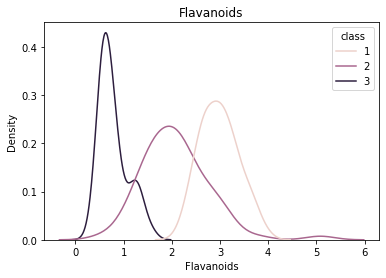

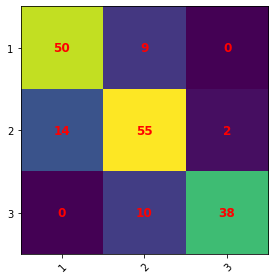

accuracy : 80.34 percents


In [22]:
classes = raw_data["class"]

plt.title("Flavanoids")
sns.kdeplot(data=raw_data, x="Flavanoids", hue="class")

def compare_flavanoid(element):
    if(element["Flavanoids"] < 1):
        return 3
    else:
        return 1 if element["Flavanoids"] > 2.6 else 2

predictions_results = predict_class(compare_flavanoid)
plot_confusion_matrix(classes_names, classes, predictions_results)

##### Modèle + règle basée sur la variable "Alcohol"

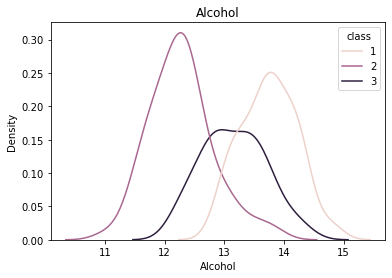

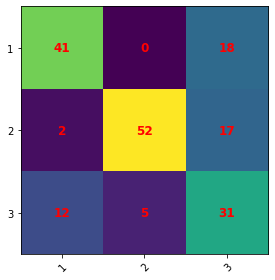

accuracy : 69.66 percents


In [23]:
plt.title("Alcohol")
sns.kdeplot(data=raw_data, x="Alcohol", hue="class")
def compare_alcohol(element):
    if(element["Alcohol"] < 12.5):
        return 2
    else:
        return 1 if element["Alcohol"] > 13.5 else 3

predictions_results = predict_class(compare_alcohol)
plot_confusion_matrix(classes_names, classes, predictions_results)

#### partie b)

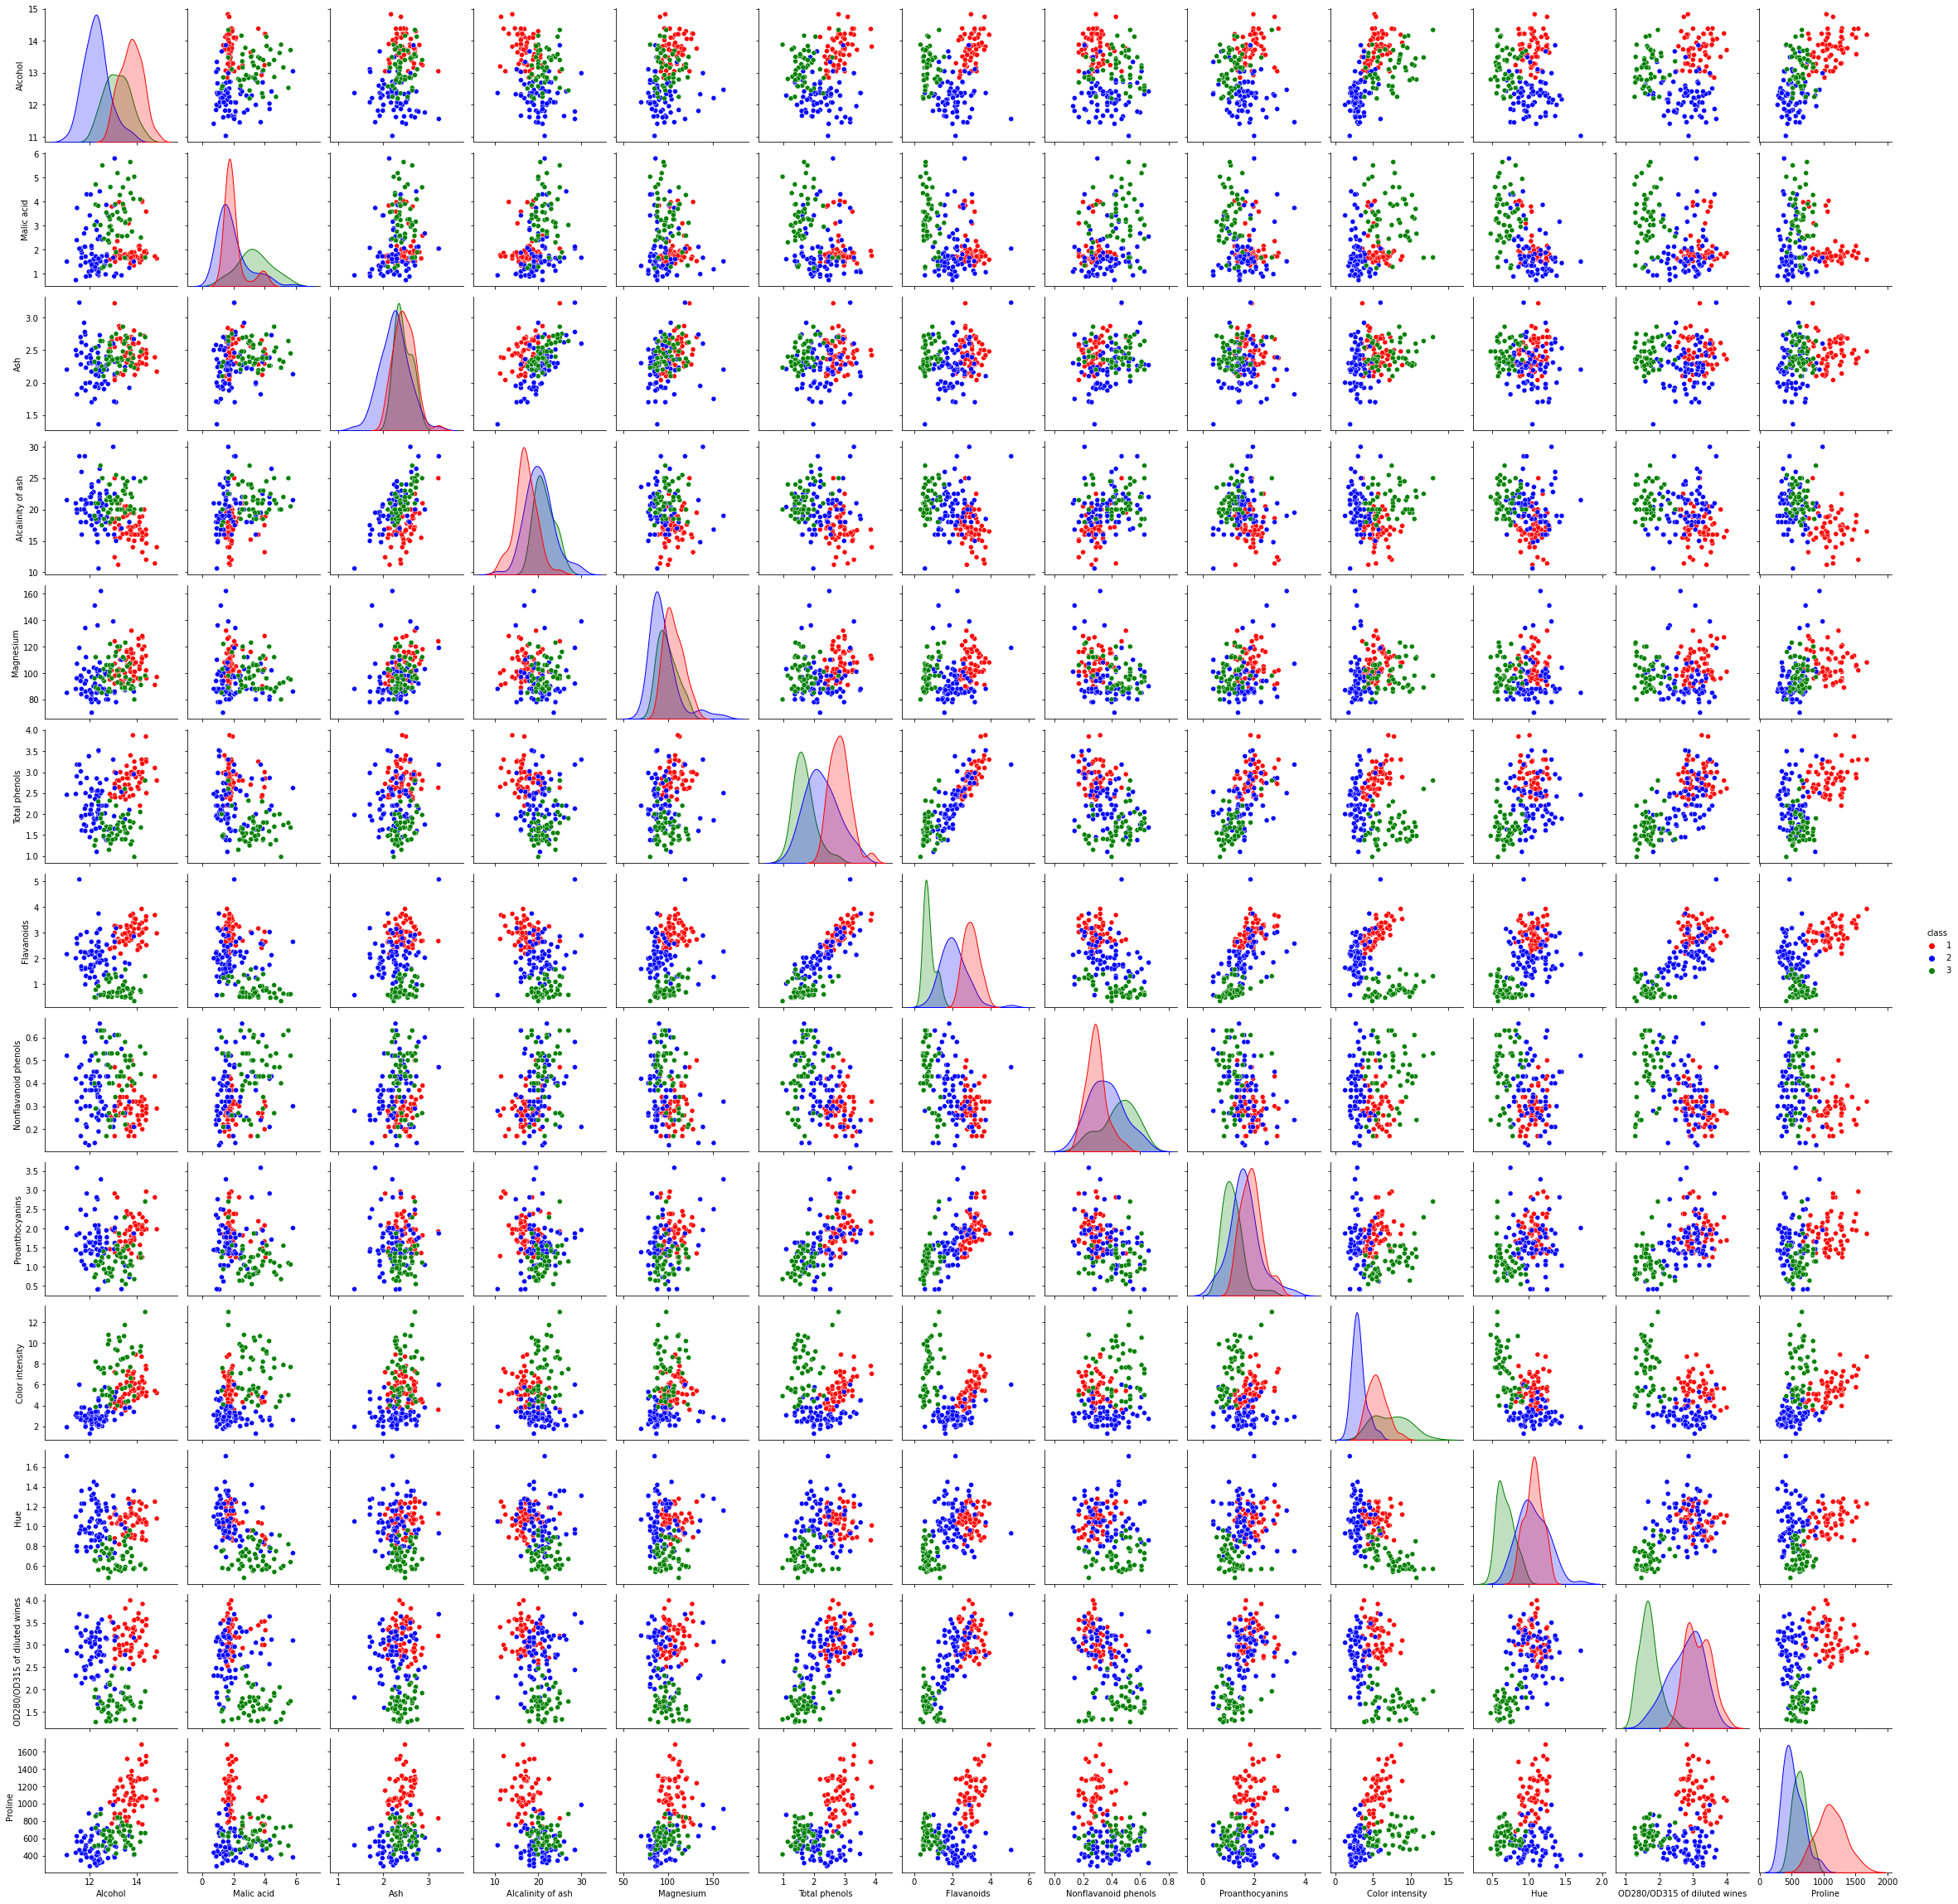

In [24]:
sns.pairplot(raw_data, hue="class", palette={1: 'red', 2: 'blue', 3: 'green'})

Afin d'étudier la relation entre les différentes caractéristiques nous générons pour chaque couple de caractéristiques possibles (donc 13 x 13) un scatter plot. Nous cherchons en particulier des graphiques où il est possible de distinguer le plus clairement possible les nuages de points représentant les différentes classes. 

Ceci indique qu'il sera possible de distinguer la classe d'un élément à partir de ces caractéristiques et donc établir des règles sur la base de ces dernières. 

Nous repérons les duos suivants que nous affichons de manière plus claire dessous :
* Flavanoids et Proline
* OD280/OD315 of diluted wines et Proline

Nous créons donc deux modèles, pour les 2 cas à partir de règles basées sur un duo de variables. Nous évaluons ensuite chaque modèle en générant une matrice de confusion ainsi qu'en calculant l'accuracy

##### Modèle + règle basée sur les variables "Flavanoids" et "Proline"

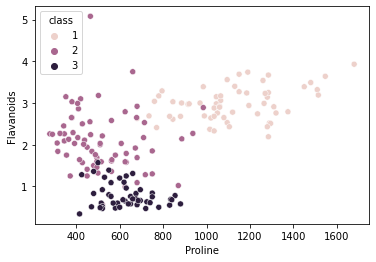

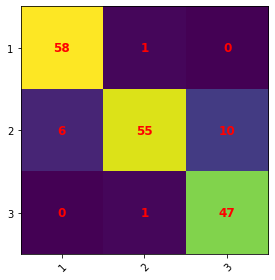

accuracy : 89.89 percents


In [25]:
sns.scatterplot(data=raw_data, x="Proline", y="Flavanoids", hue="class")
# ------------------------------------------- Modèle C : Proline + Flavanoids -
def compare_proline_flavanoids(element):
    if element["Flavanoids"] < 1.4:
        return 3
    else:
        if element["Proline"] < 700:
            return 2
        else:
            return 1

predictions_results = predict_class(compare_proline_flavanoids)
plot_confusion_matrix(classes_names, classes, predictions_results)

##### Modèle + règle basée sur les variables "OD280/OD315 of diluted wines" et "Proline"

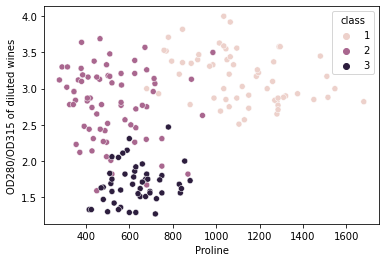

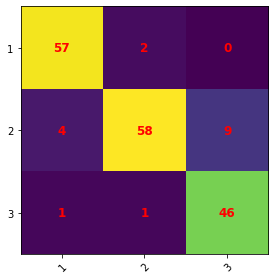

accuracy : 90.45 percents


In [26]:
sns.scatterplot(data=raw_data, x="Proline", y="OD280/OD315 of diluted wines", hue="class")
# ------------------------------------------- Modèle C : Proline + OD280 -
def compare_proline_OD280(element):
    if element["OD280/OD315 of diluted wines"] < 2.2:
        return 3
    else:
        if element["Proline"] < 750:
            return 2
        else:
            return 1

predictions_results = predict_class(compare_proline_OD280)
plot_confusion_matrix(classes_names, classes,predictions_results)

#### Constat Intermédiaire - partie 2

Nous réalisons que devoir manuellement trouver des règles et non seulement fastidieux mais surtout terriblement inneficace. Nos règles ne permettent que d'effectuer des séparations linéaires de l'espace. Ceci suppose donc que les classes ayant des plages de valeurs impliquant des chevauchement ne seront jamais totalement identifiées.

Cette étape illustre bien les limites de la programmation classique. En nous chargeant nous même des règles, nous sommes confrontés à plusieurs problématiques. Par exemple, ceci implique d'analyser et de récupérer bon nombres d'information sur l'ensemble des données à traiter. Ceci demande donc d'acquérir au préalable des connaissances spécifiques sur le sujet afin de bien comprendre les valeurs affichées. 

Ces problèmes seraient résolus en utilisant par exemple un réseau de neurones. Avec ce dernier, le programme s'écrit de lui-même à partir des données. Certes, nous n'avons plus la main mise sur les caractéristiques choisies pour effectuer la classification ce qui peut causer certains soucis mais cette analyse sera beaucoup plus systématique et plus efficace.

### 3. L’algorithme des k plus proches voisins (k-NN)

In [27]:
# Nombre de voisins à tenir compte
neighbors_count = [1, 2, 3, 5, 7, 10]
n_folds = 5 # nbre. de partage dans une validation croisée
split = 10

In [28]:
# Fonctions utiles pour le LVQ et le KNN
from random import randrange
import random
from sklearn.preprocessing import StandardScaler
random.seed(1)

# Calcul de la distance Euclidienne entre 2 éléments
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return math.sqrt(distance)

def cross_validation_split(dataset, n_folds):
    np.random.shuffle(dataset)
    folds = np.array_split(dataset, n_folds)
    return folds

def cross_validation_split_knn(dataset, n_folds):
    result = list()
    cp = list(dataset)
    size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        current_fold = list()
        # Shuffle "à la main" pour palier à certains bugs (inspiré des fonctions fournies)
        while len(current_fold) < size:
            index = randrange(len(cp))
            current_fold.append(cp.pop(index))

        result.append(current_fold)

    return result

# Créer une séparation  de test et d'entraînement
def train_test_split(dataset, split=0.60):
    train = list()
    train_size = split * len(dataset)
    dataset_copy = list(dataset)

    while len(train) < train_size:
        index = randrange(len(dataset_copy))
        train.append(dataset_copy.pop(index))
    return train, dataset_copy


In [29]:
# Fonctions du KNN

# récupère les num_neighbors voisins les plus proches
def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))

    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

def knn_predict(train, test_row, num_neighbors):
    neighbors = get_neighbors(train, test_row, num_neighbors)
    output = [row[-1] for row in neighbors]
    prediction = max(set(output), key = output.count)
    return prediction

# Effectue l'évaluation  selon KNN et renvoie les prédictions de classe
def do_knn(train_set, test_set, k):
    predictions = list()
    for row in test_set:
        prediction = knn_predict(train_set, row, k)
        predictions.append(prediction)
    return predictions

def compute_accuracy(predicted, truth):
    correct_count = 0
    for i in range(len(predicted)):
        if predicted[i] == truth[i]:
            correct_count += 1
    return correct_count / float(len(predicted)) * 100.0

In [30]:
# normalisation des données
data = raw_data.loc[:, raw_data.columns != "class"]
df_knn_normalized = (data - data.min()) / (data.max() - data.min())
df_knn_normalized["class"] = raw_data["class"]

# Chaque clé correspond à une validation. Chaque clé d'une validation correspond à un K
accuracies_results = {
    "cross": {},
    "hold": {}
}


for k in neighbors_count:
    accuracy_total_hold = 0.0
    accuracy_total_cross = 0.0

    # Split les données et prédit avec KNN (hold-out)
    for i in range(split):
        train, test = train_test_split(df_knn_normalized.values)
        predictions = do_knn(train, test, k)
        # Calcule l'accuracy
        accuracy = compute_accuracy(predictions, [row[-1] for row in test])
        accuracy_total_hold += accuracy

    accuracies_results["hold"][k] = accuracy_total_hold / split

    # validation croisé
    folds = cross_validation_split_knn(df_knn_normalized.values.tolist(), n_folds)
    for validation_fold_i in range(len(folds)):
        folds_copy = folds.copy()
        test_set = folds_copy.pop(validation_fold_i)
        train_set = np.concatenate(folds_copy)
        predictions = do_knn(train_set, test_set, k)
        accuracy_total_cross += compute_accuracy(predictions, [row[-1] for row in test_set])

    accuracies_results["cross"][k] = accuracy_total_cross / float(n_folds)

display(accuracies_results)


{'cross': {1: 94.85714285714286,
  2: 95.99999999999997,
  3: 95.42857142857142,
  5: 94.85714285714285,
  7: 96.57142857142858,
  10: 96.57142857142856},
 'hold': {1: 94.7887323943662,
  2: 93.38028169014083,
  3: 96.61971830985915,
  5: 94.22535211267606,
  7: 96.33802816901407,
  10: 96.90140845070422}}

### 4. Évaluation des modèles

In [31]:
# todo

### 5. L’algorithme LVQ

#### # méthodes fournies
rappels :
* codebook = ensemble des vecteurs prototypes
* 2 phases pour le créer : init des vecteurs prot. / mise à jour progressive des vecteurs prot. sur n epochs

pour commencer on normalise l'ensemble des valeurs qu'on stocke dans une nouvelle structure (un tableau numpy)

In [32]:
# ==================================== CODE DONNE (et adapté par endroits) ====================================
random.seed(1)

# création du codebook
def random_codebook(train):
    n_records = len(train)
    n_features = len(train[0])
    codebook = [train[random.randrange(n_records)][i] for i in range(n_features)]
    return codebook

# Entraînement d'un codebook
def train_codebook(train, n_codevectors, lrate, epochs, verbose):
    codebook = [random_codebook(train) for i in range(n_codevectors)]    
    for epoch in range(epochs):
        rate = lrate * (1.0-(epoch/float(epochs)))
        random.shuffle(train)
        for row in train:
            # bmu => prototype le + proche du point saisi aléatoirement     
            bmu = get_best_matching_unit(codebook, row)
            error = row[1:] - bmu[1:]
            fixingValues = rate * error
            # si le prototype est de la même classe on 
            bmu[1:] += fixingValues if bmu[0] == row[0] else -fixingValues
        if verbose:
            print('>epoch=%d, lrate=%.3f' % (epoch, rate))
    return codebook

# Localiser le meilleur prototype
def get_best_matching_unit(codebook, test_row):
    distances = list()
    for codevector in codebook:
        dist = euclidean_distance(codevector, test_row)
        distances.append((codevector, dist))
    distances.sort(key=lambda tup: tup[1])
    return distances[0][0]

# Prédiction selon les vecteurs d'un codebook donné
def predict(codebook, test_row):
    bmu = get_best_matching_unit(codebook, test_row)
    # retourne la classe
    return bmu[0]

def predict_lvq(train, test, n_codebooks, lrate, epochs, verbose=False):
    codebook = train_codebook(train, n_codebooks, lrate, epochs, verbose)
    return [predict(codebook, row) for row in test]

learning rate = 0.500000, nbr of epochs = 100, nbr of codevectors = 15, nbr of folds = 5


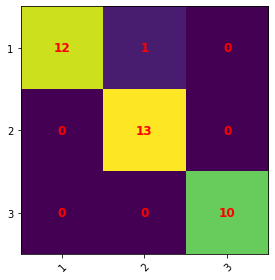

accuracy : 97.22 percents


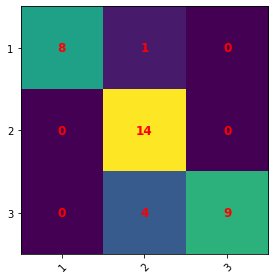

accuracy : 86.11 percents


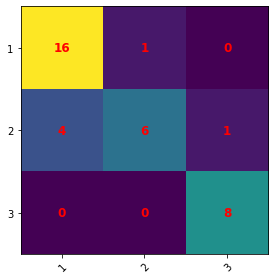

accuracy : 83.33 percents


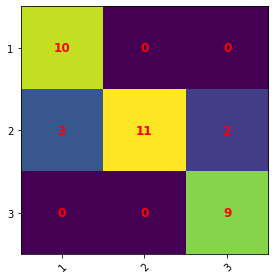

accuracy : 85.71 percents


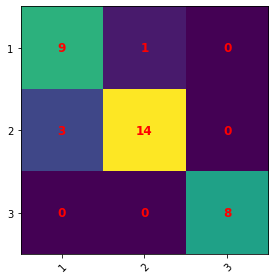

accuracy : 88.57 percents


In [33]:
scaler = StandardScaler()

df_normalized_data = raw_data.copy()
columns = df_normalized_data.columns.values[1:]

# normalisation
df_normalized_data[columns] = scaler.fit_transform(df_normalized_data[columns])

np_normalized_data = df_normalized_data.to_numpy()
np.random.shuffle(np_normalized_data)

# ces valeurs m'ont l'air pas mal
learn_rate = 0.5
n_epochs = 100
n_codevectors = 15
n_folds = 5

folds = cross_validation_split(np_normalized_data, n_folds)
print("learning rate = %f, nbr of epochs = %d, nbr of codevectors = %d, nbr of folds = %d" % (learn_rate, n_epochs,
                                                                                             n_codevectors, n_folds))
for validation_fold_i in range(len(folds)):
    
    folds_copy = folds.copy()
    test_set = folds_copy.pop(validation_fold_i)
    train_set = np.concatenate(folds_copy)
    predicted = predict_lvq(train_set, test_set, n_codevectors,learn_rate, n_epochs, False )
    
    actual = [row[0] for row in test_set]
    print("=====================================")
    plot_confusion_matrix(classes_names, actual, predicted)
    
    


#### Observations

Pour la valeur des hyperparamètres, nous avons lançé plusieurs fois uen validation croisée à 5 folds en testant différentes valeurs pour le learning rate, le nombre de vecteurs prototypes, nombre d'epochs

En étudiant l'accuracy obtenue pour ces différents modèles, nous nous sommes arrêtés sur les valeurs suivantes :
* learning rate = 0.5
* nombre de vecteurs prototypes = 10
* nombre d'epochs = 100

Les résultats obtenus sont affichés ci-dessus sous forme de matrice de confusion, l'accuracy est également mentionnée.
Nous obtenons une accuracy en moyenne de 0.91 ce qui est un résultat plutôt acceptable.

Nous pouvons observer grâce à la matrice de confusion que la majeure partie des erreurs concerne le fait que des vins prédit comme appartenant à la classe 1 sont en fait des vins de classe 2 (cellule (2,1)). En revanche tous les vins que le modèle a orienté vers la classe 3 sont bel et bien de la classe 3, il reconnaît donc cette classe de manière fiable.

Nous remarquons, si nous nous basons sur les valeurs d'accuracy que LVQ fournit un modèle moins performant que KNN (environ 90% d'accuracy pour LVQ contre environ 100% pour KNN). 